In [1]:
import pandas as pd
import numpy as np

from math import asin,acos,atan 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

from skopt import gp_minimize

from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from collections import OrderedDict
from sklearn.utils.random import check_random_state

# Bayesian opt###
from sklearn.model_selection import cross_val_score

from skopt.space import Real, Integer,Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import graphviz

In [2]:
def _protected_exponent(x):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x) < 100, np.exp(x), 0.)

exp= make_function(function=_protected_exponent,
                    name='exp',
                     arity=1)

In [3]:
def _indicator(x,a):
        return np.where(x < a, 1, 0)

ind= make_function(function=_indicator,
                    name='ind',
                    arity=2)

In [4]:
function_set_s = [exp,'add', 'sub', 'mul', 'div',
                  'inv','neg','log']

In [65]:
df_2var= pd.read_csv('option_sep_5.csv', sep=',')
df_2var.head()

,Unnamed: 0,X.1,X,date,s_price,total_return,strike,call_put,best_bid,best_offer,last_trade_date,volume,open_interest,implied_volatility,time_maturity,time_maturity_rate,interest_rate,abs_moneyness,moneyness,adj_moneyness
0,1,2488568,3231566,2022-01-27,4326.51,-0.005384,3900,P,83.7,84.7,2022-01-27,78,8935,0.318037,77,0.210959,0.538803,-0.098581,0.900395,-0.228436
1,2,2488569,3231567,2022-01-27,4326.51,-0.005384,3925,P,88.0,89.0,2022-01-27,1864,1117,0.313920,77,0.210959,0.538803,-0.092802,0.906167,-0.214524
2,3,2488570,3231568,2022-01-27,4326.51,-0.005384,3930,P,88.9,90.0,2022-01-27,321,67,0.313203,77,0.210959,0.538803,-0.091647,0.907322,-0.211752
3,4,2488571,3231569,2022-01-27,4326.51,-0.005384,3950,P,92.5,93.6,2022-01-27,558,8655,0.309848,77,0.210959,0.538803,-0.087024,0.911939,-0.200701
4,5,2488589,3231587,2022-01-27,4326.51,-0.005384,4225,P,45.8,46.5,2022-01-27,162,511,0.346465,8,0.021918,0.518718,-0.023462,0.976427,-0.161136


In [66]:
feature_names = ['moneyness','time_maturity_rate']
target_name = 'implied_volatility'

X = df_2var[feature_names]
y = np.log(df_2var[target_name])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=2)
X_train.head()

,moneyness,time_maturity_rate
1194,0.991250,0.060274
834,1.074432,0.060274
305,0.997443,0.386301
911,0.944846,0.098630
573,0.975831,0.136986


In [68]:
y_train.head()

1194   -1.236097
834    -1.571083
305    -1.441879
911    -1.171202
573    -1.288888
Name: implied_volatility, dtype: float64

In [50]:
est_gp=SymbolicRegressor(generations=100, stopping_criteria=0.001,
                         max_samples=0.9, verbose=1,
                         random_state=0, parsimony_coefficient=0.001,
                         function_set=function_set_s)


# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(500,2000,name='population_size'),
          Real(0, 0.44, name='p_crossover'),
          Real(0, 0.28, name='p_subtree_mutation'),
          Real(0, 0.18, name='p_hoist_mutation'),
          Real(0, 0.1, name='p_point_mutation'),
          Categorical(['grow', 'full', 'half and half'], name='init_method')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    est_gp.set_params(**params)

    return -np.mean(cross_val_score(est_gp, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [ ]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

In [52]:
res_gp.fun

0.041442436339699566

In [54]:
print((res_gp.x[0], res_gp.x[1],res_gp.x[2], res_gp.x[3],res_gp.x[4],res_gp.x[5]))

(1291, 0.3231575018169707, 0.24585258039759195, 0.18, 0.07030498617662953, 'grow')


In [ ]:
est_gp_sep=SymbolicRegressor(population_size=1231,init_method='grow',
                            generations=100, stopping_criteria=0.001,
                            max_samples=0.9, verbose=1,
                            p_crossover=0.34, p_subtree_mutation=0.222,
                            p_hoist_mutation=0.183, p_point_mutation=0.022,
                            random_state=0, parsimony_coefficient=0.001,
                            function_set=function_set_s)
est_gp_sep.fit(X_train, y_train)

In [70]:
print(est_gp_sep._program)

mul(neg(X0), sub(mul(X0, X0), inv(add(log(X1), sub(-0.687, X1)))))


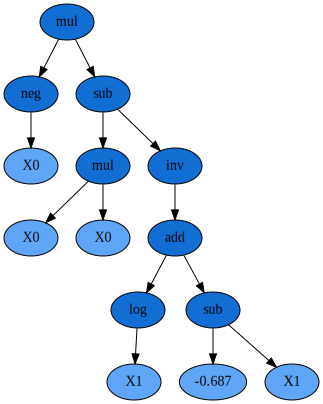

In [71]:
dot_data = est_gp_sep._program.export_graphviz()
graph = graphviz.Source(dot_data)
#graph.render('/Users/jiayiluo/Dropbox/symbolic/simulations/image_sim_5_error1', format='png', cleanup=True)
graph

In [16]:
models = {'sr': est_gp_sep,
         'lm': make_pipeline(StandardScaler(), RidgeCV()),
         'rf': RandomForestRegressor()}

In [ ]:
for model_name, model_instance in models.items():
    print('Training model {}'.format(model_name))
    model_instance.fit(X_train, y_train)

In [18]:
for model_name, model_instance in models.items():
    y_test_pred = model_instance.predict(X_test)
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    
    print('Model {}: \n mae: {} \n mse: {} \n'.format(model_name, mae, mse))

Model sr: 
 mae: 0.007482288182519081 
 mse: 0.0001499689515212186 

Model lm: 
 mae: 0.013873937055815641 
 mse: 0.00040779007917463646 

Model rf: 
 mae: 0.0019456887386029202 
 mse: 8.965810663821705e-06 

